# Autoencoders and VAEs

Learning Outcomes:
- Apply AEs and VAEs to different tasks: image compression and image generation.
- Visualize the latent space.
- Evaluate the impact of different regularization functions and hyper-parameters on the latent representations.
- Generate images and interpolate between images using the VAE.
- Transfer the learnt representation for use in supervised tasks.

## Library Imports

In [10]:
%load_ext autoreload
%autoreload 2

import random

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


## The MNIST dataset
The MNIST dataset consists of **70,000 grayscale images** of handwritten digits (0 to 9). Each image is a **28x28 pixel** grayscale image. The training set contains 60,000 images while the test set contains 10,000 images. The grayscale values are integers ranging from 0 (black) to 255 (white). However, typicially the data is normalized to range between 0 and 1 for deep learning models.

The MNIST dataset can be downloaded from the **torchvision** library, using the following code:

In [2]:
# Load the MNIST dataset
transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

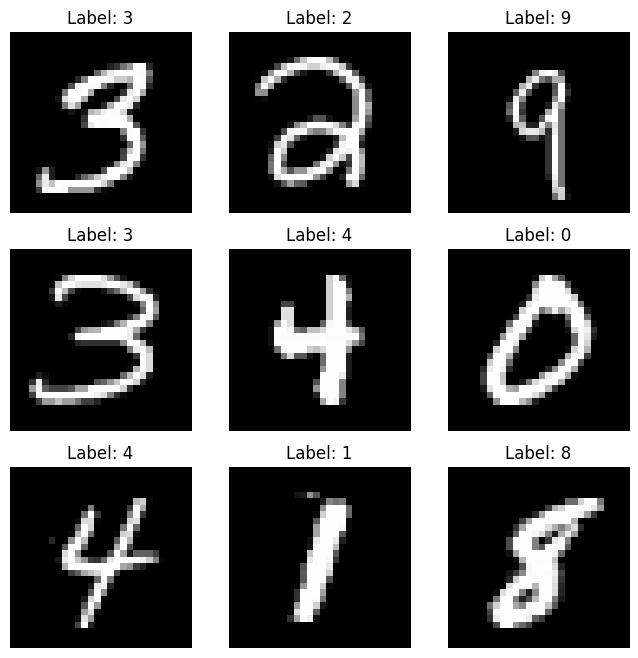

In [3]:
# Plot 9 random images from the MNIST train dataset
def plot_images(img_dataset):
    """Plots 9 random images from the given dataset

    Args:
        img_dataset (torch.utils.data.Dataset): The dataset to plot images from
    """
    # Set up a 3x3 grid for plotting 9 random images
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    
    # Plot 9 random images from the img_dataset
    for i in range(1, cols * rows + 1):
        random_idx = torch.randint(len(img_dataset), size=(1,)).item()  # Pick a random index
        img, label = img_dataset[random_idx]  # Get the image and its label
        figure.add_subplot(rows, cols, i)  # Add subplot
        plt.title(f'Label: {label}')  # Set title to show the label
        plt.axis("off")  # Turn off axis
        plt.imshow(img.squeeze(), cmap="gray")  # Plot image
    
    plt.show()  # Display the figure

plot_images(train_dataset)

**Exercise.** The models that we will be using in this notebook will mainly consist of fully connected layers and activations (no convolutions). Prepare the data for use with such models (complete all the `TODO` flags below):
1. Flatten the data.
2. Normalize pixel values to the interval $[0, 1]$.

In [35]:
# Flatten the images
train_dataset = train_dataset.data.view( , ).float() # TODO: Complete with the appropriate dimensions
train_dataset = # TODO: Normalize pixel values.

# TODO: Repeat the same for the test dataset

SyntaxError: invalid syntax (3339434928.py, line 2)

In [4]:
# %load solutions/prepare_data.py
# Flatten the images
train_dataset = train_dataset.data.view(-1, 28*28).float()
train_dataset = train_dataset / 255.0
test_dataset = test_dataset.data.view(-1, 28*28).float()
test_dataset = test_dataset / 255.0

print(train_dataset.shape)
print(test_dataset.shape)

torch.Size([60000, 784])
torch.Size([10000, 784])


## A couple of examples
We begin with a couple of examples that will prove useful in the sequel:
1. How to train PCA on MNIST using `scikit-learn`.
2. How to train a simple AE on MNIST using `Pytorch`.
Don't hesitate to refer back to these examples in needed.

### I.1. **Example.** training and evaluating PCA
In order to train and evaluate a PCA model, we use the PCA class provided by the `scikit-learn` dataset.

In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Instantiate a PCA model with the desired number of principal components
pca = PCA(n_components=10)

# Fit the PCA model to the training data
pca.fit(train_dataset)

# Evaluate the PCA model on the training and test data
pca_reconstruction_train = pca.inverse_transform(pca.transform(train_dataset))
pca_reconstruction_test = pca.inverse_transform(pca.transform(test_dataset))
pca_mse_train = mean_squared_error(train_dataset, pca_reconstruction_train)
pca_mse_test = mean_squared_error(test_dataset, pca_reconstruction_test)

# Print the PCA reconstruction MSE on the training and test data
print(f"PCA Reconstruction MSE on the train set: {pca_mse_train:.6f}")
print(f"PCA Reconstruction MSE on the test set: {pca_mse_test:.6f}")

PCA Reconstruction MSE on the train set: 0.034423
PCA Reconstruction MSE on the test set: 0.034074


### I.2. **Example.** Training and evaluating an AE

In order to train and evaluate an AE model, we will use the `pytorch` library. For this example we will train a simple autoencoder with one fully connected layer plus activation in the encoder/decoder, and a free hidden dimension parameter. The steps we follow are:
1. We create an `Autoencoder` class with the desired architecture and a free hidden dimension parameter.
2. We prepare the data loaders to train the AE model using minibatch gradient descent.
3. We instatiate a model of the `Autoencoder` class with the desired hidden dimension parameter.
4. We define the loss and optimizer that will be used to train the AE.
5. We perform the actual training.
6. We evaluate the results.

#### I.2.1. Create the `Autoencoder` class
In `pytorch`, a neural network model is defined as a class that inherits from `nn.Module`. The class must have an `__init__` method that defines the layers of the network and a `forward` method that defines how input data is passed through the network. The `forward` method should return the output of the network. In this case, the `Autoencoder` class has an encoder and a decoder. Fully connected layers are called `Linear` in `Pytorch`.

In [6]:
# Create the Autoencoder class

class Autoencoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder: Linear layer with ReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(28*28, hidden_dim),
            nn.ReLU()
        )

        # Decoder: Linear layer with Sigmoid activation
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode the input
        x = self.encoder(x)
        # Decode the latent representation
        x = self.decoder(x)
        return x

#### I.2.2. Prepare the data loaders
Data loaders are used to iterate through data in batches.

In [7]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### I.2.3. Instantiate the model
We instantiate the model with a hidden dimension of 10. The `.to(device)` method moves the model to the GPU if available


In [8]:
hidden_dim = 10

simple_ae = Autoencoder(hidden_dim=hidden_dim).to(device)

#### I.2.4. Define loss and optimizer
Common loss functions can be access through pytorch's `.nn` module, whereas common optimizers are found in pytorch's `.optim` module. We have already imported both, as `nn` and `optim` respectively.

In [11]:
criterion = nn.MSELoss() # Mean Squared Error loss
optimizer = optim.Adam(simple_ae.parameters(), lr=1e-3) # Adam optimizer

#### I.2.5. Train the AE
Before each gradient descent iteration, it is extremely important to reset the gradients of the weights to 0 using the method `.zero_grad()`, otherwise, the new gradients are accumulated to those of previous iterations.

In [15]:
num_epochs = 10

for epoch in range(num_epochs):
    simple_ae.train()
    running_loss = 0.0
    for images in train_loader:
        # Move images to device
        images = images.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = simple_ae(images)
        
        # Compute loss
        loss = criterion(outputs, images)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

Epoch [1/10], Loss: 0.066640
Epoch [2/10], Loss: 0.041444
Epoch [3/10], Loss: 0.036839
Epoch [4/10], Loss: 0.034987
Epoch [5/10], Loss: 0.034021
Epoch [6/10], Loss: 0.033425
Epoch [7/10], Loss: 0.033123
Epoch [8/10], Loss: 0.032919
Epoch [9/10], Loss: 0.032747
Epoch [10/10], Loss: 0.032613


#### I.2.6. Evaluate the results

In [17]:
simple_ae.eval()
test_loss = 0.0
with torch.no_grad():
    for images in test_loader:
        # Move images to the device
        images = images.to(device)
        
        # Forward pass
        outputs = simple_ae(images)
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.032152


## Undercomplete Autoencoder vs PCA

The objective of this section is to review the following concepts, seen during the lesson:
1. A linear undercomplete autoencoder learnt on the reconstruction loss is equivalent to PCA.
2. An undercomplete autoencoder with nonlinear activation is more powerful than PCA.
3. An undercomplete autoencoder with "high capacity" is able to memorize the training data (overfitting happens).
### Linear undercomplete AE vs PCA
In order to compare linear undercomplete AEs and PCA, we will perform a benchmarking experiment. We will compare the PCA model with $p$ principal components with an undercomplete autoencoder with $p$ hidden dimensions, for different values of $p$. As a matter of fact, we will be using multiple autoencoder architectures, the hidden dimension will always be $p$, but the width and depth of the autoencoders should vary (use at least the 9 possible combinations of 3 different widths and 3 different heights).

#### Running the benchmark
Complete all the `TODO` flags below and perform the benchmark. Feel free to change the arrays `hidden_dims`, `ae_widths` and `ae_depths`.

In [ ]:
hidden_dims = [1, 2, 4, 8, 16, 32, 64]
ae_widths = [64, 128, 256]
ae_depths = [1, 2, 3]

def run_benchmark(hidden_dims, ae_widths, ae_depths):
    """Runs a benchmark on the given hidden dimensions, autoencoder widths, and autoencoder depths

    Args:
        hidden_dims (list): A list of hidden dimensions / principal components to test
        ae_widths (list): A list of autoencoder widths to test
        ae_depths (list): A list of autoencoder depths to test
    """
    
    # Initialize dictionaries to store results
    pca_train_loss = {}
    pca_val_loss = {}
    ae_train_loss = {}
    ae_val_loss = {}

    # Iterate through the hidden dimensions
    for p in hidden_dims:
        # Train the PCA model
        print(f"Training PCA model with {p} hidden dims")

        # TODO: Train a PCA model with p hidden dimensions

        mse_train_pca = # TODO: Evaluate the PCA model on train data
        mse_val_pca = # TODO: Evaluate the PCA model on validation data
        pca_train_loss[p] = mse_train_pca
        pca_val_loss[p] = mse_val_pca


        for width in ae_widths:
            for depth in ae_depths:
                # Train the autoencoder model
                print(f"Training autoencoder with {p} hidden dims, width={width}, depth={depth}")

                # TODO: Initialize and train the autoencoder model
                
                mse_train_ae = # TODO: Evaluate the autoencoder model on train data
                mse_val_ae = # TODO: Evaluate the autoencoder model on validation data
                ae_train_loss[(p, width, depth)] = mse_train_ae
                ae_val_loss[(p, width, depth)] = mse_val_ae
                print(f"Train MSE: {mse_train_ae}, Val MSE: {mse_val_ae}")

    return pca_train_loss, pca_val_loss, ae_train_loss, ae_val_loss

pca_train_loss, pca_val_loss, ae_train_loss, ae_val_loss = run_benchmark(hidden_dims, ae_widths, ae_depths)


### PCA Analysis of the MNIST dataset

**Exercise:** Implement the PCA compression algorithm with 16 components by fitting it on the MNIST training data.
- Hint 1: Prepare the data by flattening the images and normalizing the pixel values so that they belong to the interval $[0,1]$
- Hint 2: The PCA algorithm is provided in the scikit-learn library

In [30]:
from sklearn.decomposition import PCA

In [9]:
# SOLUTION
train_flattened = train_dataset.data.view(-1, 28*28).float()
train_flattened = train_flattened / 255.0

pca = PCA(n_components=16)
pca.fit(train_flattened)

PCA(n_components=16)

**Exercise:** 
- Evaluate the error of the PCA algorith by computing the Mean Square Error (MSE) on both the training dataset and the test dataset. 
- Use the PCA algorithm to compare 10 random images from the test dataset with their reconstructions.

In [10]:
from sklearn.metrics import mean_squared_error

In [11]:
# SOLUTION
test_flattened = test_dataset.data.view(-1, 28*28).float()
test_flattened = test_flattened / 255.0

pca_mse_train = mean_squared_error(train_flattened, pca.inverse_transform(pca.transform(train_flattened)))
pca_mse_test = mean_squared_error(test_flattened, pca.inverse_transform(pca.transform(test_flattened)))

print(f"PCA Reconstruction MSE on the train set: {pca_mse_train:.4f}")
print(f"PCA Reconstruction MSE on the test set: {pca_mse_test:.4f}")

PCA Reconstruction MSE on the train set: 0.0000
PCA Reconstruction MSE on the test set: 0.0283


In [34]:
# Function to visualize original vs reconstructed images
def visualize_reconstruction(original, reconstructed, title):
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    
    for i in range(10):
        # Original images
        axes[0, i].imshow(original[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.suptitle(title)
    plt.show()

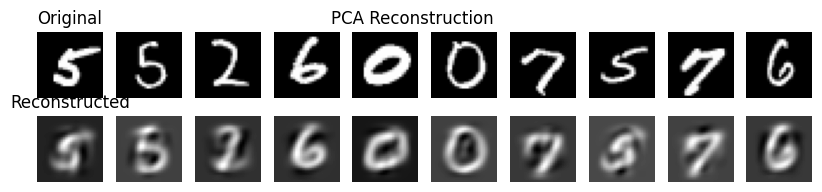

In [35]:
original = random.choices(test_flattened, k=10)
reconstructed = pca.inverse_transform(pca.transform(original))
visualize_reconstruction(original, reconstructed, "PCA Reconstruction")

**Exercise:** Build a pipeline to evaluate the PCA reconstruction MSE for a list of different values of principal components.

In [37]:
def plot_pca_mse(principal_components):
    """Plots the PCA reconstruction MSE for different number of principal components

    Args:
        principal_components (list): list of principal components values to try
    """

    pca_mse_train = []
    pca_mse_test = []

    for n in principal_components:
        pca = PCA(n_components=n)
        pca.fit(train_flattened)

        pca_mse_train.append(mean_squared_error(train_flattened, pca.inverse_transform(pca.transform(train_flattened))))
        pca_mse_test.append(mean_squared_error(test_flattened, pca.inverse_transform(pca.transform(test_flattened))))

    plt.plot(principal_components, pca_mse_train, label='Train')
    plt.plot(principal_components, pca_mse_test, label='Test')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('MSE')
    plt.title('PCA Reconstruction MSE')
    plt.legend()
    plt.show()

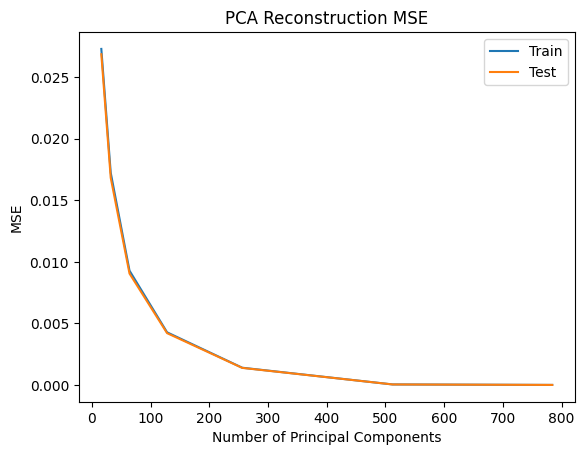

In [39]:
principal_components = [16, 32, 64, 128, 256, 512, 784]
plot_pca_mse(principal_components)

**Questions**: 
- What do you observe from the above graph? 
- Based on the above graph, is there overfitting?
- How many principal components would you choose? Let's call your answer $n$
- How does $n$ compare to the number of pixels in the original images?
- Use the PCA algorithm with $n$ principal components to compare 10 random images from the test set with their reconstructions.

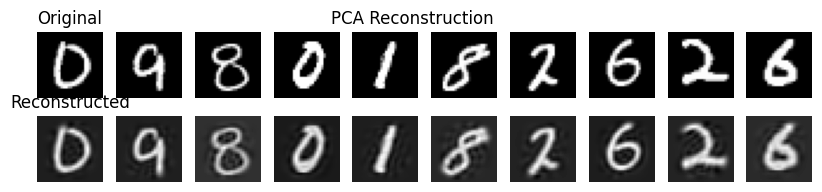

In [42]:
pca = PCA(n_components=128)
pca.fit(train_flattened)

original = random.choices(test_flattened, k=10)
reconstructed = pca.inverse_transform(pca.transform(original))
visualize_reconstruction(original, reconstructed, "PCA Reconstruction")

### Dimensionality Reduction with an undercomplete autoencoder
**Questions:**
- Is an *undercomplete* autoencoder the same thing as a *linear autoencoder*?
- Do wo need a regularization term in order to train an undercomplete autoencoder?
- Will an undercomplete autoencoder with say 16 hidden layers be able to overfit (memorize) the MNIST training dataset? 
- Given that the input images are normalized to contain pixel values in the interval $[0,1]$, what should the output of the last layer of the encoder be? How can we achieve this?

**Exercise:** Build an autoencoder architecture consistig of:
1. The encoder
    - A fully connected layer with 128 neurons
    - a ReLU activation function
    - A fully connected layer with ?? neurons

2. The feature space
    - A feature space with an adjustable number of hidden dimensions (this should be parameter of the model).

3. The decoder
    - A fully connected layer with 128 neurons
    - A ReLU activation function
    - A fully connected layer with ?? neurons
    - A sigmoid activation function

In [48]:
# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),  # Latent space
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image into a vector
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        reconstructed = reconstructed.view(-1, 1, 28, 28)  # Reshape back to the image
        return reconstructed


**Exercise:** 
- Train an autoencoder with the above architecture and 16 hidden dimensions.
- Use the Mean Square Error (MSE) loss as the optimization criterion.
- Use the Adam optimizer with a learning rate of 0.001.
- Train the model for 10 epochs.

In [49]:
# SOLUTION

# Set latent space dimension (you can experiment with different sizes)
latent_dim = 16
model = Autoencoder(latent_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training the Autoencoder
def train(model, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [50]:

# Train the model for 10 epochs (you can adjust the number of epochs)
train(model, train_loader, num_epochs=10)


Epoch [1/10], Loss: 0.0376
Epoch [2/10], Loss: 0.0189
Epoch [3/10], Loss: 0.0168
Epoch [4/10], Loss: 0.0156
Epoch [5/10], Loss: 0.0148
Epoch [6/10], Loss: 0.0141
Epoch [7/10], Loss: 0.0136
Epoch [8/10], Loss: 0.0132
Epoch [9/10], Loss: 0.0129
Epoch [10/10], Loss: 0.0126


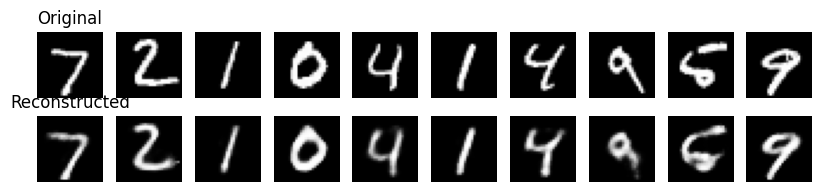

In [51]:

# Evaluate the model and visualize the results
def test_and_visualize(model, test_loader):
    model.eval()
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            break  # Just take the first batch for visualization
    
    # Move images back to CPU for plotting
    images = images.cpu()
    outputs = outputs.cpu()
    
    # Visualize original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    
    for i in range(10):
        # Original images
        axes[0, i].imshow(images[i].squeeze(0), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(outputs[i].squeeze(0), cmap='gray')
        axes[1, i].axis('off')
    
    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    plt.show()

    autoencoder_mse = nn.MSELoss()
    return 

# Test the model and visualize some results
test_and_visualize(model, test_loader)


## Image Generation with VAEs

## Image interpolation

## Visualization of the latent space

# Transferable representations